# MLOpsへの画像データのスコアリング
チュートリアル：https://docs.h2o.ai/h2o-hydrogen-torch/tutorials/predictions/tutorial-2b

手順：
1. H2O Hydrogen Torchにで物体検出モデルを作成
2. MLOpsデプロイメントファイルをダウンロード
3. MLOpsへファイルをアップロードし、デプロイ
4. デプロイ先のエンドポイントへリクエストを実施（以下内容）

## スコアリングリクエストの実施

In [1]:
import base64
import json

import cv2
import requests

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# MLOpsのモデルデプロイ先エンドポイントURL
URL = "https://model.internal.dedicated.h2o.ai/bffea6ac-818e-41bd-81d2-aba7228243n81/model/score"

In [3]:
# スコアリングを実施するデータの読み込み
img1 = cv2.imread("scoring_samples/street2.jpg")
img2 = cv2.imread("scoring_samples/street4.jpg")

print(type(img1))
img1.shape

<class 'numpy.ndarray'>


(480, 640, 3)

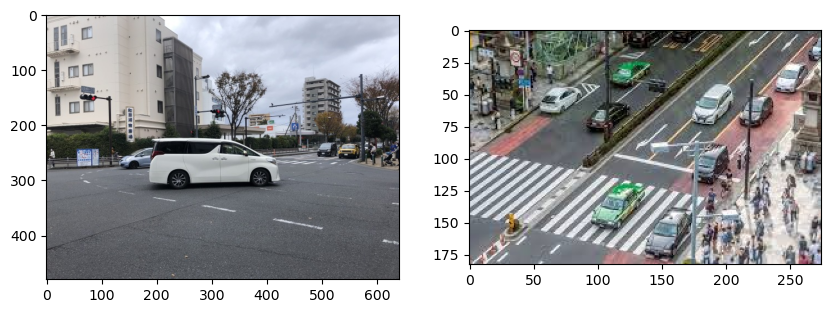

In [5]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

OpenCV（GBR）から、matplotlibでの画像表示形式（RGB）に変換  
参考：https://wp.nakanishi.pro/python/56/

In [12]:
# 画像データをbase64でエンコード
input1 = base64.b64encode(cv2.imencode(".png", img1)[1]).decode()
input2 = base64.b64encode(cv2.imencode(".png", img2)[1]).decode()

print(type(input1))
print(len(input1))
input1[:100]

<class 'str'>
737580


'iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAIAAAC6s0uzAAAgAElEQVR4AYzBa69k6Vnm+f91P2utiNinzMr0AXtcmMPYWCWhMdhV'

In [13]:
# APIにPOSTするjsonデータ
data = {"fields": ["input"], "rows": [[input1], [input2]]}

In [14]:
#data

In [15]:
%%time

# APIへのPOSTリクエスト
r = requests.post(url=URL, json=data)
r

CPU times: user 57.6 ms, sys: 5.4 ms, total: 63 ms
Wall time: 8.11 s


<Response [200]>

In [16]:
ret = r.json()
print(type(ret))
ret.keys()

<class 'dict'>


dict_keys(['fields', 'id', 'score'])

In [17]:
ret['fields']

['output']

In [18]:
ret['id']

'89e13a2c-eb98-485f-8fde-62a5cda09b42'

In [19]:
print(type(ret["score"][0][0]))
print(len(ret["score"][0][0]))
ret["score"][0][0][:500]      # json形式の文字列

<class 'str'>
9436


'{"boxes": [[[185.04693603515625, 220.80738830566406, 423.6729736328125, 328.8059997558594], [491.1566162109375, 230.98141479492188, 528.9373779296875, 257.2830810546875], [528.1627197265625, 233.26296997070312, 571.58740234375, 261.77337646484375], [132.7318115234375, 238.1092529296875, 194.25413513183594, 279.69085693359375], [134.96310424804688, 255.9060821533203, 174.59024047851562, 280.43292236328125], [61.76885223388672, 129.81455993652344, 91.47068786621094, 156.0215606689453], [46.4570388'

In [20]:
# json形式の文字列を辞書に変換
ret_json = json.loads(ret["score"][0][0])
print(type(ret_json))
ret_json.keys()

<class 'dict'>


dict_keys(['boxes', 'confidences', 'classes'])

In [21]:
for k, v in ret_json.items():
    print(k, ' : ', np.array(v).shape)

# 最初の次元（2）がリクエストした画像枚数
# スコアリング結果のオブジェクト数は100に固定

boxes  :  (2, 100, 4)
confidences  :  (2, 100)
classes  :  (2, 100)


In [22]:
print(ret_json['classes'][0])      # 1枚目の画像のClass。1Class（車）のみで、0としている。-1は背景

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [23]:
print(ret_json['confidences'][0])      # 1枚目の画像のClassの予測確率

[0.9973172545433044, 0.9931825995445251, 0.9746171832084656, 0.9179860353469849, 0.8393992185592651, 0.8178733587265015, 0.7615457773208618, 0.5532547831535339, 0.4376327395439148, 0.27691182494163513, 0.20649214088916779, 0.17180287837982178, 0.16848209500312805, 0.13978725671768188, 0.12354356050491333, 0.10653027892112732, 0.10481325536966324, 0.08682754635810852, 0.06991931051015854, 0.05748114734888077, 0.05630352720618248, 0.053157344460487366, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [24]:
print(ret_json['boxes'][0])      # 1枚目の画像のClassのバウンディングボックス

[[185.04693603515625, 220.80738830566406, 423.6729736328125, 328.8059997558594], [491.1566162109375, 230.98141479492188, 528.9373779296875, 257.2830810546875], [528.1627197265625, 233.26296997070312, 571.58740234375, 261.77337646484375], [132.7318115234375, 238.1092529296875, 194.25413513183594, 279.69085693359375], [134.96310424804688, 255.9060821533203, 174.59024047851562, 280.43292236328125], [61.76885223388672, 129.81455993652344, 91.47068786621094, 156.0215606689453], [46.45703887939453, 8.710501670837402, 61.10009765625, 19.198352813720703], [214.0235137939453, 272.7542419433594, 264.6231384277344, 317.41656494140625], [173.46876525878906, 210.3842315673828, 342.6977844238281, 287.6060791015625], [358.2450866699219, 260.0865783691406, 415.889404296875, 312.5617370605469], [42.49311447143555, 10.05086612701416, 57.008052825927734, 19.48069190979004], [157.75714111328125, 2.4611144065856934, 169.69381713867188, 12.133319854736328], [114.68550872802734, 219.0399169921875, 205.111526

## バウンデングボックスの描画

In [25]:
import torch
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

バウンディングボックス重ね合わせ機能 : https://pytorch.org/vision/stable/generated/torchvision.utils.draw_bounding_boxes.html

その他参考 : https://github.com/yukismd/DataScience_Tutorials/blob/main/PyTorch_learning/image_using_pretrained.ipynb

In [26]:
imgt1 = read_image("scoring_samples/street2.jpg")     # torch.Tensorとして画像を読み込む
print(type(imgt1))
imgt1.size()

<class 'torch.Tensor'>


torch.Size([3, 480, 640])

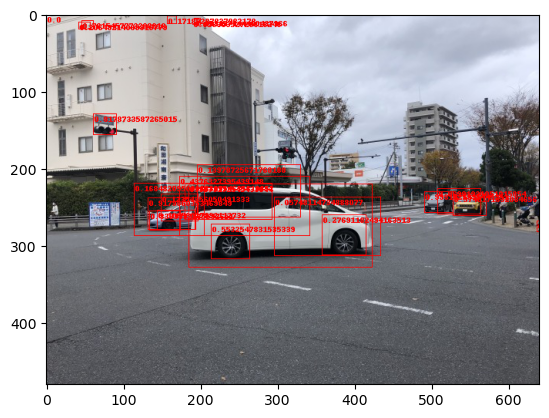

In [27]:
# そのままプロット

b_boxes = ret_json['boxes'][0]
#class_labels = ret_json['classes'][0]
class_labels = ret_json['confidences'][0]      # 予測確率をラベルとしてみる

plot_box = draw_bounding_boxes(
    image=imgt1,
    boxes=torch.from_numpy(np.array(b_boxes)), 
    labels=[str(i) for i in class_labels],
    colors="red"
)
plt.imshow(plot_box.permute(1, 2, 0))
plt.show()

In [28]:
# 予測確率の閾値を指定できるようにする
def plot_bbox(img, index, threshold):
    probs = np.array(ret_json['confidences'][index] )[np.array(ret_json['confidences'][index] ) > threshold]
    b_boxes = np.array(ret_json['boxes'][index])[np.array(ret_json['confidences'][index] ) > threshold]

    plot_box = draw_bounding_boxes(
        image=img,
        boxes=torch.from_numpy(b_boxes), 
        labels=[str(i) for i in probs],
        colors="red",
    )
    plt.imshow(plot_box.permute(1, 2, 0))
    plt.show()

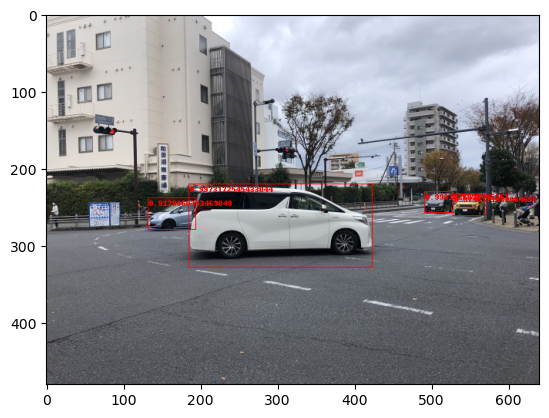

In [29]:
plot_bbox(img=imgt1, index=0, threshold=0.9)

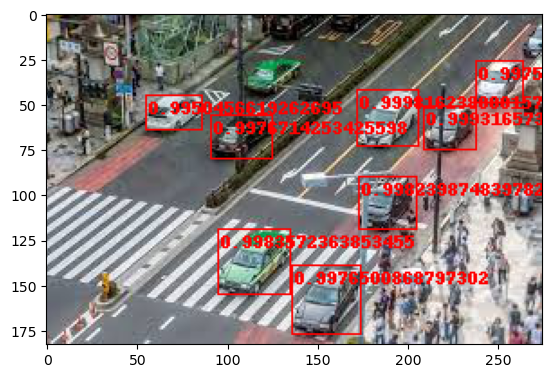

In [30]:
# スコアリングを実施したもう一枚の画像
plot_bbox(img=read_image("scoring_samples/street4.jpg"), index=1, threshold=0.95)